In [16]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys
from torch.utils.data import Subset, DataLoader
from sklearn.decomposition import PCA
import networkx as nx
sys.path.append("../hyperLAI")
sys.path.append("../../")
sys.path.append("../../libraries/")
from utils.model_utils import *
from features.hyperLAIdataset import HyperLoader
from models.fc_model import fc_model
from HypHC.optim.radam import RAdam
from HypHC.utils.poincare import project
from HypHC.utils.visualization import plot_tree_from_leaves
from HypHC.utils.linkage import nn_merge_uf_fast_np, sl_from_embeddings
from HypHC.utils.metrics import dasgupta_cost
from tqdm import tqdm_notebook

In [17]:
def plot_weights_pca(embeddings, labels, annotations=None):
    '''
    Plot embeddings. Uncomment/comment as necessary depending on if you want raw embeddings or PCA
    '''
#     weights_pca = PCA().fit_transform(embeddings)
#     scplot = sns.scatterplot(x=weights_pca[:,0], y=weights_pca[:,1], hue=labels)
    scplot = sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels)
#     plt.xlabel("PC1")
#     plt.ylabel("PC2")
#     plt.title("PCA of Embedding Weights")
    plt.xlabel("Embedding 1")
    plt.ylabel("Embedding 2")
    plt.title("Embedding Weights")

    if annotations is not None:
        for line in range(len(labels)):
#             if weights_pca[line,1] > -0.3:
#             if annotations[line] != "Hazara":
#                 continue
            scplot.text(embeddings[line,0]+0.001, embeddings[line,1], 
                         annotations[line], horizontalalignment='left', color='black', size=8)


In [18]:
model_dir = "/scratch/users/patelas/hyperLAI/models/fc_models/subpop_models/east_asians/lr_negthree_temp_negfour/"
config = read_config(model_dir + "fc_config.json")
indices = np.load("/scratch/users/patelas/hyperLAI/ancestry_training_splits/80_10_10/test_indices.npy")

In [19]:
dataset = HyperLoader(config["data_dir"], indices, config["restrict_labels"], config["chromosome"])
# variance_filter(dataset, train_indices, config["variance_filter"])
eval_loader = DataLoader(dataset, batch_size=64)

In [20]:
model = fc_model(dataset.snps.shape[1], config["num_int_layers"], config["int_layer_sizes"], config["embedding_size"], 
                 config["dropout_vals"], config["temperature"], config["init_size"], config["min_scale"], config["max_scale"])
model_info = torch.load("%smodel.pt"%(model_dir))
model.load_state_dict(model_info["model_state"])


<All keys matched successfully>

In [21]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
model.eval()
embeddings, suppop_labels, pop_labels = [], [], []
with torch.no_grad():
    for i, (snp_data, suppop, pop) in enumerate(eval_loader):
        embs = model(snp_data.float().to(device))
        embeddings.append(embs.cpu())
        suppop_labels.append(suppop)
        pop_labels.append(pop)

In [22]:
embeddings = torch.cat(embeddings).numpy()
suppop_labels = torch.cat(suppop_labels).numpy()
pop_labels = torch.cat(pop_labels).numpy()

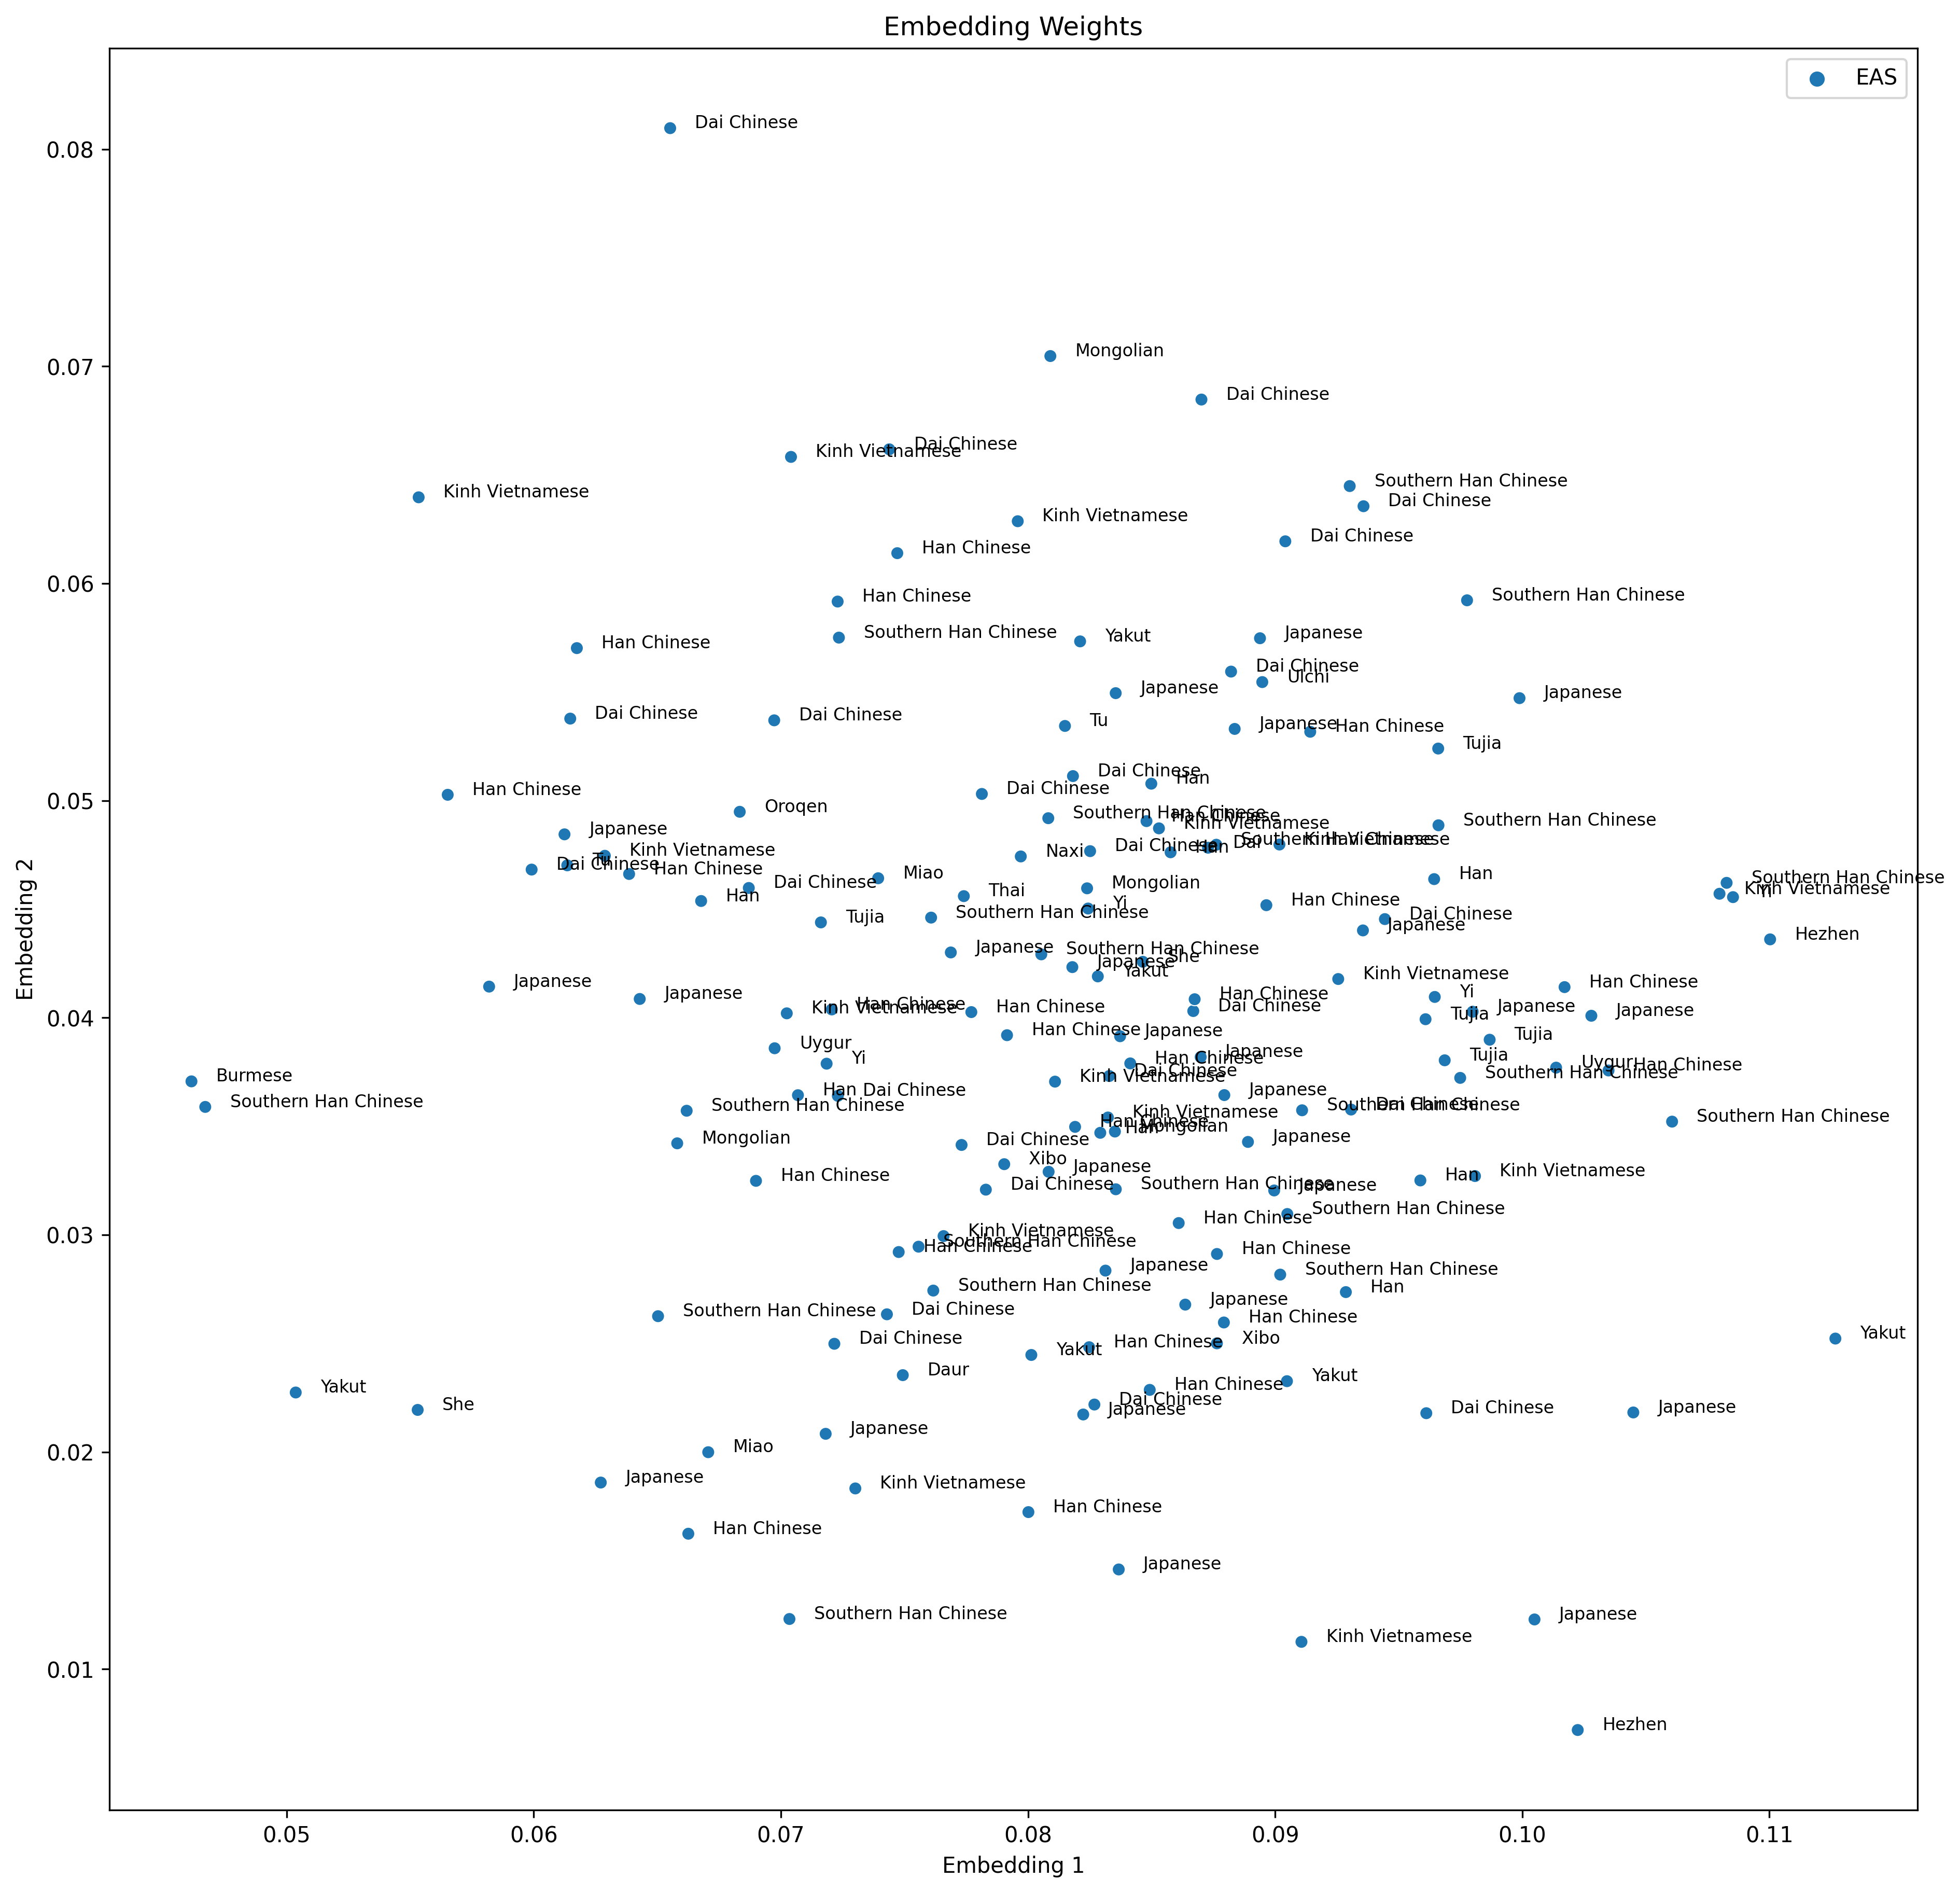

In [23]:
plt.figure(figsize=[15, 15], dpi=300)
sp_full = [dataset.suppop_label_index[x] for x in suppop_labels]
p_full = [dataset.pop_label_index[x] for x in pop_labels]
plot_weights_pca(embeddings, sp_full, p_full)
# plt.xlim(-0.25, 0.25)
# plt.ylim(-0.4, -0.3)
plt.show()

In [24]:
def decode_tree(model, embeddings, device, fast_decoding):
    """Build a binary tree (nx graph) from leaves' embeddings. Assume points are normalized to same radius.
        Taken from HypHC repo (https://github.com/HazyResearch/HypHC)
    
    """
    with torch.no_grad():
        leaves_embeddings = model.HypLoss.normalize_embeddings(torch.tensor(embeddings).to(device))
        leaves_embeddings = project(leaves_embeddings).cpu()
    sim_fn = lambda x, y: torch.sum(x * y, dim=-1)
    if fast_decoding:
        parents = nn_merge_uf_fast_np(leaves_embeddings, S=sim_fn, partition_ratio=1.2)
    else:
        parents = sl_from_embeddings(leaves_embeddings, sim_fn)
    tree = nx.DiGraph()
    for i, j in enumerate(parents[:-1]):
        tree.add_edge(j, i)
    return tree


../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid value encountered in arctanh
  return np.tanh(t * np.arctanh(normx)) * x / normx
../../libraries/HypHC/utils/visualization.py:22: RuntimeWarning: invalid val

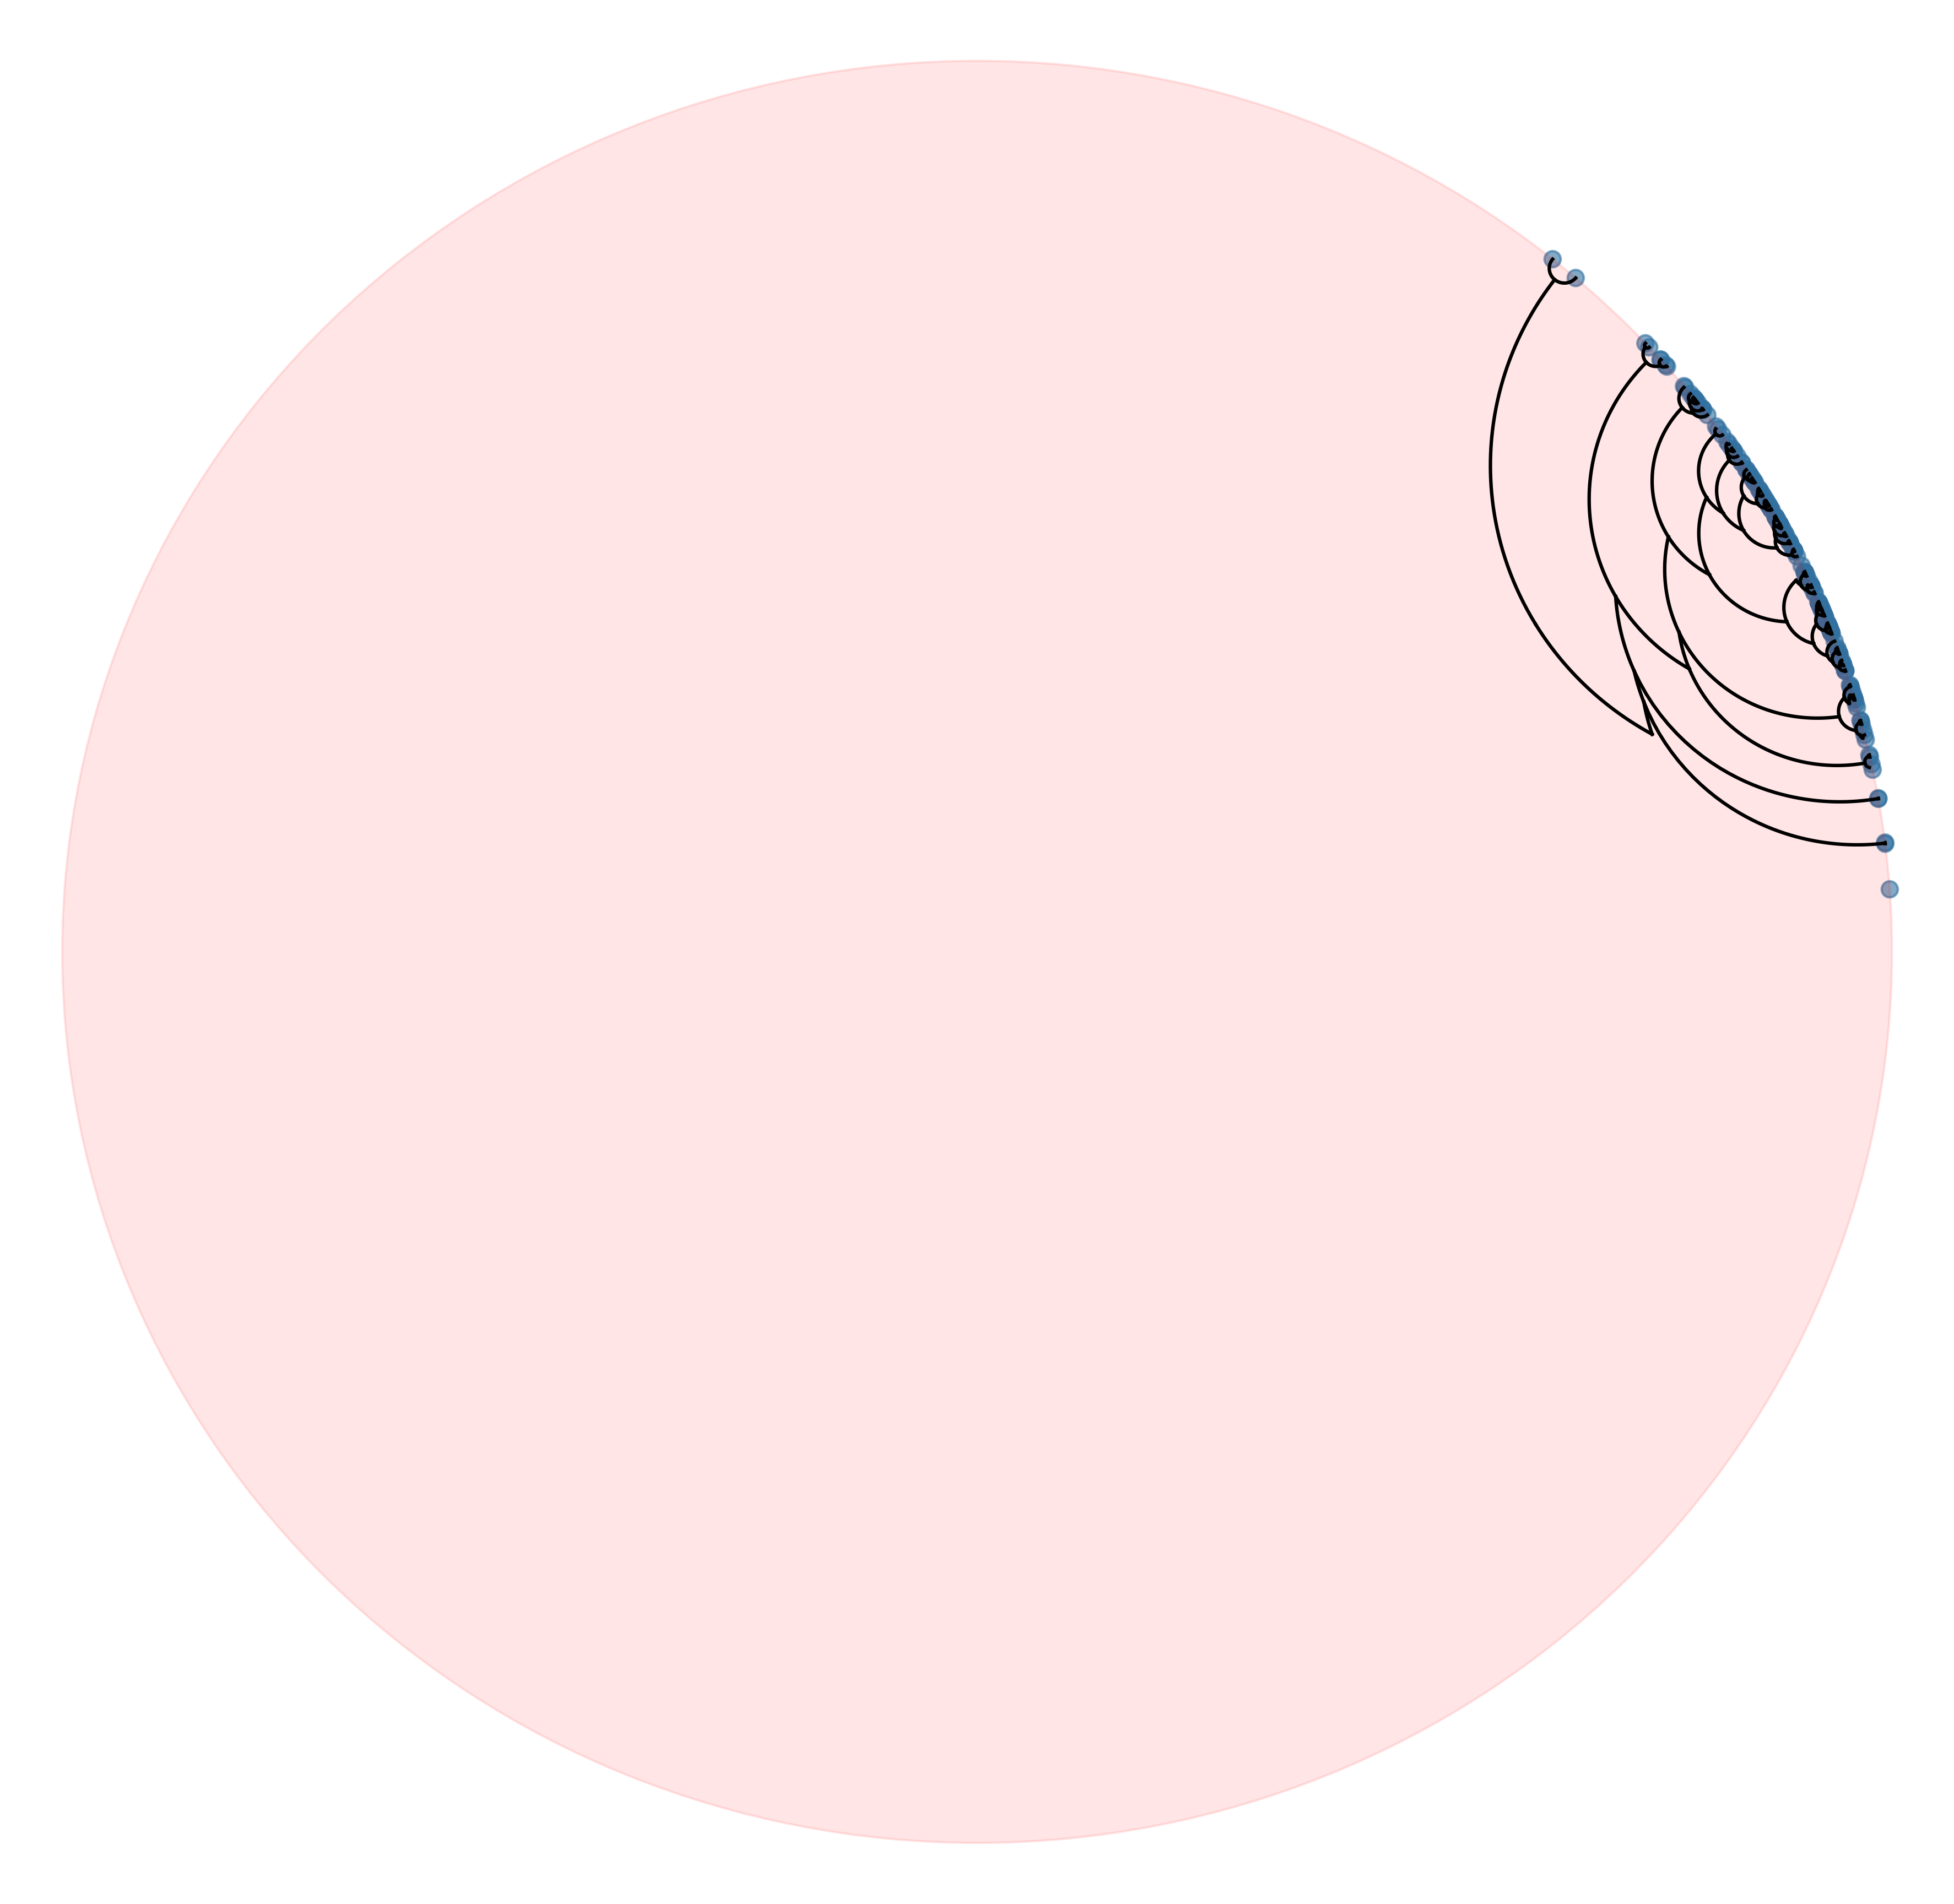

In [25]:
#Plot tree
embs_tree = embeddings
tree = decode_tree(model, embs_tree, device, True)
with torch.no_grad():
    embs_normed = model.HypLoss.normalize_embeddings(torch.tensor(embs_tree).to(device))
    leaves_embeddings = project(embs_normed).cpu().numpy()
fig = plt.figure(figsize=(15, 15), dpi=300)
ax = fig.add_subplot(111)
ax = plot_tree_from_leaves(ax, tree, leaves_embeddings * 100, labels=sp_full)

# Uncomment to add subpopulation labels - but it's very crowded
# for line in range(len(suppop_labels)):
#     ax.text(leaves_embeddings[line,0] * 100 +0.001, leaves_embeddings[line,1] * 100, 
#                  p_full[line], ha='left', 
#             color='black', va="baseline", rotation=45, size=8)

plt.show()
